### Install packages

In [49]:
# !pip install opencv-python
# !pip install k4a
# !pip install open3d
# !pip install pyk4a
# !pip install --upgrade lxml

### Import dependencies

In [50]:
import os
import time
import uuid
import cv2
import numpy as np
import pyk4a
from pyk4a import PyK4A, Config, depth_image_to_color_camera
from matplotlib import pyplot as plt
import lxml.etree 
from lxml.builder import E

### Settings

In [51]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")
OBJECT_CLASS = "flash_drive"

OBJECT_PATH = os.path.join(IMAGE_PATH, OBJECT_CLASS)

RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")
ANNOTATED_IMAGE_PATH = os.path.join(OBJECT_PATH, "annotation")
YOLO_LABEL_PATH = os.path.join(OBJECT_PATH, "yolo")
PASCAL_LABEL_PATH = os.path.join(OBJECT_PATH, "pascal_voc")

GRID_SHAPE = (5,5)
RESTRICTED_AREA = 20

MIN_OBJECT_SIZE = 15
MAX_OBJECT_SIZE = 500

#Amount of depth images taken to average one depth image 
AVERAGING_ITTERATIONS = 10

OBJECT_NAME = OBJECT_CLASS
OBJECTS = ["cup", "bowl", "bottle", "plate", "pen", "book", 
           "stapler", "hole_puncher", "flash_drive", "smartphone"]

# Corners of Desk
DESK_CORNERS = {
    "xmin": 340,
    "xmax": 940,
    "ymin": 60,
    "ymax": 660
}

# K4A Settings
BRIGHTNESS = 128
CONTRAST = 5
EXPOSURE = 16_670
WHITE_BALANCE = 4_000

### Create folders to store images and annotations

In [52]:
# Create images folder
if not os.path.exists(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)

# Create folder for object
if not os.path.exists(OBJECT_PATH):
    os.mkdir(OBJECT_PATH)
    
# Create folder rgb
if not os.path.exists(RGB_IMAGE_PATH):
    os.mkdir(RGB_IMAGE_PATH)
    
# Create folder depth
if not os.path.exists(DEPTH_IMAGE_PATH):
    os.mkdir(DEPTH_IMAGE_PATH)
    
# Create folder annotation
if not os.path.exists(ANNOTATED_IMAGE_PATH):
    os.mkdir(ANNOTATED_IMAGE_PATH)
    
# Create folder yolo label
if not os.path.exists(YOLO_LABEL_PATH):
    os.mkdir(YOLO_LABEL_PATH)
    
# Create folder yolo label
if not os.path.exists(PASCAL_LABEL_PATH):
    os.mkdir(PASCAL_LABEL_PATH)

### Helper Functions

In [53]:
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    img = img.copy()
    img_h, img_w, _ = img.shape
    h, w = DESK_CORNERS['ymax'] - DESK_CORNERS['ymin'], DESK_CORNERS['xmax'] - DESK_CORNERS['xmin']
    rows, cols = grid_shape
    rows, cols = rows + 2, cols + 2
    dy, dx = h / rows, w / cols
    
    # draw vertical lines
    x_start = int((img_w - w) / 2)
    x_end = int(w + x_start)
    y_start = int((img_h - h) / 2)
    y_end = int(h + y_start)
    
    for x in np.linspace(start = x_start + RESTRICTED_AREA, stop= x_end - RESTRICTED_AREA, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, y_start + RESTRICTED_AREA), (x, y_end - RESTRICTED_AREA), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start= y_start + RESTRICTED_AREA, stop= y_end - RESTRICTED_AREA, num=rows-1):
        y = int(round(y))
        cv2.line(img, (x_start + RESTRICTED_AREA, y), (x_end - RESTRICTED_AREA, y), color=color, thickness=thickness)

    cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color=(0, 0, 255), thickness=thickness)

    return img

### Filters the passed contours based on some criteria (e.g. contours ouside of desk-area, too little in size etc.)

In [54]:
def get_filtered_contours(contours):
    # Confines of the desk
    filtered_contours = []
    
    for contour in contours:
        x, y, w, h, = cv2.boundingRect(contour) 

        if w < MIN_OBJECT_SIZE and h < MIN_OBJECT_SIZE:
            continue
            
        if w > MAX_OBJECT_SIZE and h > MAX_OBJECT_SIZE:
            continue

        if x+w > DESK_CORNERS['xmax'] or y+h > DESK_CORNERS['ymax']:
            pass

        if w*h < MAX_OBJECT_SIZE:
            pass 

        if w/h > 2:
            pass

        filtered_contours.append((x, y, x+w, y+h)) 
    return filtered_contours

### Fills hole in the dilated image

In [55]:
def fill_holes(dilate):
    im_floodfill = dilate.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = dilate.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point
    flood_start = (DESK_CORNERS['xmin'] + RESTRICTED_AREA, DESK_CORNERS['ymin'] + RESTRICTED_AREA)
    cv2.floodFill(im_floodfill, mask, flood_start, 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    
    return cv2.bitwise_or(dilate, im_floodfill_inv)

### Stores the annotation in the YOLO format

In [56]:
def get_yolo(width, height, y_min, y_max, x_min, x_max, file):
    
    obj = OBJECTS.index(OBJECT_NAME)
    
    x_center = ((x_min + x_max) / 2) / width
    y_center = ((y_min + y_max) / 2) / height
    width = (x_max - x_min) / width
    height = (y_max - y_min) / height

    file_name = str(file) + '.txt'

    f = open(os.path.join(YOLO_LABEL_PATH, file_name), 'x')
    f.write(f'{obj} {x_center} {y_center} {width} {height}' )

### Stores the annotation in the Pascal VOC format

In [57]:
def get_pascal_voc(width, height, y_min, y_max, x_min, x_max, file):
    file_name_picture = str(file) + ".png"
    file_name = str(file) + ".xml"
    
    E = lxml.builder.ElementMaker()
    ANNOTATION = E.annotation
    FOLDER = E.folder
    FILENAME = E.filename
    PATH = E.path
    SOURCE = E.source
    DATABASE = E.database
    SIZE = E.size
    WIDTH = E.width
    HEIGHT = E.height
    DEPTH = E.depth
    SEGMENTED = E.segmented
    OBJECT = E.object
    NAME = E.name
    POSE = E.pose
    TRUNCATED = E.truncated
    DIFFICULT = E.difficult
    BNDBOX = E.bndbox
    XMIN = E.xmin
    YMIN = E.ymin
    XMAX = E.xmax
    YMAX = E.ymax
    
    doc = ANNOTATION(
            FOLDER("pascal_voc"),
            FILENAME(file_name_picture),
            PATH(os.path.join(RGB_IMAGE_PATH, file_name_picture)),
            SOURCE(
                DATABASE("Unknown")
            ),
            SIZE(
                WIDTH(str(width)),
                HEIGHT(str(height)),
                DEPTH("3"),
            ),
            SEGMENTED("0"),
            OBJECT(
                NAME(OBJECT_NAME),
                POSE("Unspecified"),
                TRUNCATED("0"),
                DIFFICULT("0"),
                BNDBOX(
                    XMIN(str(x_min)),
                    YMIN(str(y_min)),
                    XMAX(str(x_max)),
                    YMAX(str(y_max)),
                )
            )
        ) 
    f = open(os.path.join(PASCAL_LABEL_PATH, file_name), 'x')
    f.write(lxml.etree.tostring(doc, pretty_print=True).decode("utf-8"))

### Used to identify edges in the depth map

**depth_img:** Depth map that comes directly out of the Azure Kinect Camera

In [58]:
def preprocess_img(depth_img):
    depth_img = depth_img.astype("uint8")
     
    # Remove pixels outside of table
    mask = np.zeros_like(depth_img)
    cv2.rectangle(mask, (DESK_CORNERS['xmin'], DESK_CORNERS['ymin']), (DESK_CORNERS['xmax'], DESK_CORNERS['ymax']), (255, 255, 255), -1)
    depth_img = cv2.bitwise_and(depth_img, mask)

    CANNY_THRESH = 10
    KERNEL_SIZE = 5
    ITERATION_COUNT = 3
    
    edged = cv2.Canny(depth_img, CANNY_THRESH, CANNY_THRESH, CANNY_THRESH)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE, KERNEL_SIZE))
    dilate = cv2.dilate(edged, kernel, iterations=ITERATION_COUNT)
    
    dilate = fill_holes(dilate)
    
    return dilate

### Get Clean Plate of Desk
The following code is used to get a clean plate of the table. This is used in a later step to identify the object on the table through differences in the height of the depth map.

Also used to fix the orientation of the table to fit inside the grid-overlay.

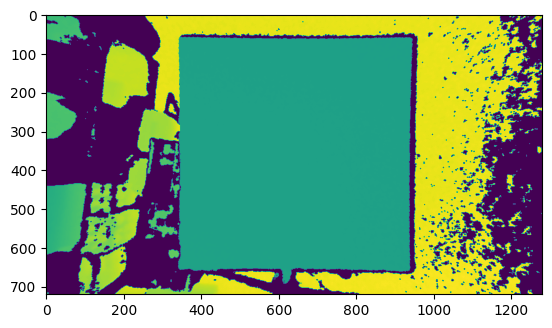

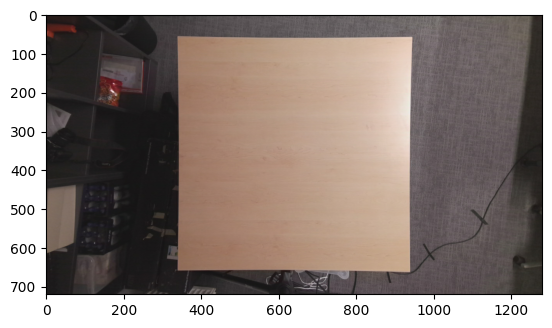

In [59]:
# Load camera with the default config
k4a = PyK4A(
    Config(
        camera_fps= pyk4a.FPS.FPS_5,
        depth_mode=pyk4a.DepthMode.WFOV_UNBINNED
    )
)
k4a.start()
while True:
    capture = k4a.get_capture()
    
    img_color = capture.color
    img_depth = capture.depth   

    # Convert Depth Image to same aspect ratio as RGB image
    img_depth = depth_image_to_color_camera(img_depth, k4a.calibration, True)
    
    # Display windows
    cv2.imshow("RGB Image", draw_grid(img_color, GRID_SHAPE, (255, 0, 0)))

    key = cv2.waitKey(1)
    if key == ord("q"):
        cv2.destroyAllWindows()
        break

# Get the next capture (blocking function)
capture = k4a.get_capture()

# Convert BGR to RGB
prev_color = capture.color
prev_color = img_color[:, :, 2::-1]
prev_depth = capture.depth
prev_depth = depth_image_to_color_camera(prev_depth, k4a.calibration, True)
depth_groundtruth = capture.depth
depth_groundtruth = depth_image_to_color_camera(depth_groundtruth, k4a.calibration, True)
rgb_groundtruth = capture.color/AVERAGING_ITTERATIONS

# Display with pyplot
plt.imshow(img_depth) 
plt.show()
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

for i in range(AVERAGING_ITTERATIONS-1):
    time.sleep(0.2)
    capture = k4a.get_capture()
    depth_sample = capture.depth
    depth_sample = depth_image_to_color_camera(depth_sample, k4a.calibration, True)
    depth_groundtruth += depth_sample
    rgb_sample = capture.color/AVERAGING_ITTERATIONS
    rgb_groundtruth += rgb_sample

depth_groundtruth = depth_groundtruth/AVERAGING_ITTERATIONS 
depth_groundtruth = preprocess_img(depth_groundtruth)
rgb_groundtruth = np.around(rgb_groundtruth, 0).astype(int)

k4a.stop()

In [60]:
def get_bounding_box_edge(depth_img):
    depth_img = depth_img.astype("uint8")

    # find the contours in the dilated image
    contours, _ = cv2.findContours(depth_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[2:])

    filtered_contours = get_filtered_contours(contours)
    print(f"Found {len(filtered_contours)} objects.")
    return filtered_contours[0] if filtered_contours else (0, 0, 0, 0)

### Capture live feed and save RGB-D images

In [61]:
screen_res = 1920, 1080
window_size = 1920 // 3, 1080 // 3

# Load camera with the default config
k4a = PyK4A(
    Config(
        camera_fps= pyk4a.FPS.FPS_5,
        depth_mode=pyk4a.DepthMode.WFOV_UNBINNED
    )
)
k4a.start()

PAGE_DOWN = 86
PAGE_UP = 85

while True:   
    # Adjust camera settings
    k4a.brightness = BRIGHTNESS
    k4a.contrast = 4#CONTRAST
    k4a.exposure = EXPOSURE
    k4a.whitebalance = WHITE_BALANCE
    
    # Capture image and depth frames
    capture = k4a.get_capture()
    img_color = capture.color
    img_depth = capture.depth 
    
    # Convert Depth Image to same aspect ratio as RGB image
    img_depth = depth_image_to_color_camera(img_depth, k4a.calibration, True)  
    
    # Display windows  
    cv2.imshow("RGB Image", draw_grid(img_color, GRID_SHAPE, (255, 0, 0)))
    cv2.moveWindow("RGB Image", 0, 0)
    
    key = cv2.waitKey(1)
    
    if key == ord('m') or key == PAGE_UP or key == PAGE_DOWN:
        # Play shutter sound
        os.system('mpg123 audio/shutter.mp3')
        
        id = f'{str(uuid.uuid1())}'
        file_name = f'{id}.png'
        
        depth_annotation = img_depth
        #rgb_annotation = img_color/AVERAGING_ITTERATIONS
        
        for i in range(AVERAGING_ITTERATIONS-1):
            time.sleep(0.2)
            
            capture = k4a.get_capture()
            depth_sample = capture.depth
            depth_sample = depth_image_to_color_camera(depth_sample, k4a.calibration, True)
            depth_annotation += depth_sample
            #rgb_sample = capture.color/AVERAGING_ITTERATIONS
            #rgb_annotation += rgb_sample
            
        depth_annotation = depth_annotation/AVERAGING_ITTERATIONS
        depth_annotation = preprocess_img(depth_annotation)
        #rgb_annotation = np.around(rgb_annotation, 0).astype(int)

        bounding_box = get_bounding_box_edge(depth_annotation)
        
        cv2.namedWindow("Dilation", cv2.WINDOW_KEEPRATIO)
        cv2.resizeWindow("Dilation", window_size[0], window_size[1])
        cv2.imshow("Dilation", depth_annotation)
        cv2.moveWindow("Dilation", screen_res[0] - window_size[0], screen_res[1] - window_size[1])
        
        if bounding_box == (0, 0, 0, 0):
            continue
            
        # Save images
        cv2.imwrite(os.path.join(RGB_IMAGE_PATH, file_name), img_color)
        cv2.imwrite(os.path.join(DEPTH_IMAGE_PATH, file_name), img_depth)
        
        x_min, y_min, x_max, y_max = bounding_box
                
        # Draw bounding box onto image
        start_point = (x_min, y_min) 
        end_point = (x_max, y_max)
        color = (255, 0, 0)  
        thickness = 1

        width, height = int(img_color.shape[1]), int(img_color.shape[0])
        rgb_rect = cv2.rectangle(img_color, start_point, end_point, color, thickness)
        
        #Save image with boundingbox
        cv2.imwrite(os.path.join(ANNOTATED_IMAGE_PATH, file_name), rgb_rect)
        
        # Save annotations
        get_yolo(width, height, y_min, y_max, x_min, x_max, id)
        get_pascal_voc(width, height, y_min, y_max, x_min, x_max, id)
             
        # Refocus RGB Image Window
        cv2.setWindowProperty("RGB Image", cv2.WND_PROP_TOPMOST, 1)
        cv2.moveWindow("RGB Image", 0, 0)
        
        # Show Dilated Image + Image with annotation
        #plt.imshow(depth_annotation)
        #plt.show()
        #plt.imshow(cv2.cvtColor(rgb_rect, cv2.COLOR_BGR2RGB))
        #plt.show()

    if key == ord("q"):
        cv2.destroyAllWindows()
        break
        
k4a.stop()

High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Directory: audio/
Playing MPEG stream 1 of 1: shutter.mp3 ...

MPEG 2.0 L III vbr 16000 mono

[0:00] Decoding of shutter.mp3 finished.


Found 1 objects.


### Code Cemetary

In [62]:
def get_bounding_box(img, table): 
    y_min = 10000
    y_max = 0
    x_min = 10000
    x_max = 0

    for x in range(370, 930):
        for y in range(70, 650):
            k = img[y, x]
            if k < (table[y,x]-4) or k > (table[y,x]+4):
                if x > x_max:
                    x_max = x #- 1
                if y > y_max:
                    y_max = y #- 1
                if x < x_min:
                    x_min = x #- 1
                if y < y_min:
                    y_min = y #- 1
    return y_min, y_max, x_min, x_max

In [63]:
def get_bounding_box_rgb(img, table):
    y_min = 10000
    y_max = 0
    x_min = 10000
    x_max = 0
    for x in range(370, 930):
        for y in range(70, 650):
            k = img[y, x]
            t = table[y, x]
            if k[0] < (t[0]-30) or k[0] > (t[0]+30) or k[1] < (t[1]-30) or k[1] > (t[1]+30) or k[2] < (t[2]-30) or k[2] > (t[2]+30) or k[3] < (t[3]-30) or k[3] > (t[3]+30):
                if x > x_max:
                    x_max = x #- 1
                if y > y_max:
                    y_max = y #- 1
                if x < x_min:
                    x_min = x #- 1
                if y < y_min:
                    y_min = y #- 1
    return y_min, y_max, x_min, x_max 

In [64]:
def get_bounding_box_preprocessed(img):
    y_min = 10000
    y_max = 0
    x_min = 10000
    x_max = 0
    for x in range(370+10, 930-10):
        for y in range(70+10, 650-10):
            k = img[y, x]
            if k > 0:
                if x > x_max:
                    x_max = x - 1
                if y > y_max:
                    y_max = y - 1
                if x < x_min:
                    x_min = x - 1
                if y < y_min:
                    y_min = y - 1
    return y_min, y_max, x_min, x_max 